In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from fbprophet import Prophet

In [2]:
df_sales = pd.read_csv('sales_train_v2.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'],  dayfirst=True)

In [3]:
df_sales_fbprophet = df_sales.loc[(df_sales['item_cnt_day']>0)&
                                #(df_sales['date']>pd.to_datetime('2014-10-01'))&
                                (df_sales['item_id']==1512)]
                                
df_sales_fbprophet = df_sales_fbprophet.groupby(['date'])['item_cnt_day'].sum().reset_index(name='item_cnt_day_total')
df_sales_fbprophet['log_item_cnt_day_total'] = np.log(df_sales_fbprophet['item_cnt_day_total'])
df_sales_fbprophet=df_sales_fbprophet[['date','log_item_cnt_day_total']]
df_sales_fbprophet


,date,log_item_cnt_day_total
0,2013-10-29,4.543295
1,2013-10-30,4.488636
2,2013-10-31,4.532599
3,2013-11-01,4.454347
4,2013-11-02,4.709530
...,...,...
326,2014-12-31,0.693147
327,2015-01-03,0.000000
328,2015-01-05,0.000000
329,2015-01-06,0.693147


In [4]:
df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date": "ds", "log_item_cnt_day_total": "y"})
df_sales_fbprophet['floor']=-2
df_sales_fbprophet['cap']=df_sales_fbprophet['y'].max()
df_sales_fbprophet

,ds,y,floor,cap
0,2013-10-29,4.543295,-2,4.70953
1,2013-10-30,4.488636,-2,4.70953
2,2013-10-31,4.532599,-2,4.70953
3,2013-11-01,4.454347,-2,4.70953
4,2013-11-02,4.709530,-2,4.70953
...,...,...,...,...
326,2014-12-31,0.693147,-2,4.70953
327,2015-01-03,0.000000,-2,4.70953
328,2015-01-05,0.000000,-2,4.70953
329,2015-01-06,0.693147,-2,4.70953


In [5]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True, 
            seasonality_mode='multiplicative', growth='logistic')
            #growth='logistic')
m.fit(df_sales_fbprophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [6]:
# find how many periods we need by finding the last day in the item
days_to_predict = pd.to_datetime('2016-1-31') - df_sales_fbprophet['ds'].max()
days_to_predict.days

386

In [7]:
# predict a few days into the future so we have a full month in November
future = m.make_future_dataframe(periods=days_to_predict.days)
future['floor']=-2
future['cap']=df_sales_fbprophet['y'].max()

future.tail()

,ds,floor,cap
712,2016-01-27,-2,4.70953
713,2016-01-28,-2,4.70953
714,2016-01-29,-2,4.70953
715,2016-01-30,-2,4.70953
716,2016-01-31,-2,4.70953


In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
712,2016-01-27,-1.455430,-2.069498,-0.838050
713,2016-01-28,-1.532944,-2.167450,-0.832033
714,2016-01-29,-1.678654,-2.303053,-1.011692
715,2016-01-30,-1.844575,-2.467567,-1.187895
716,2016-01-31,-1.811191,-2.483935,-1.167545


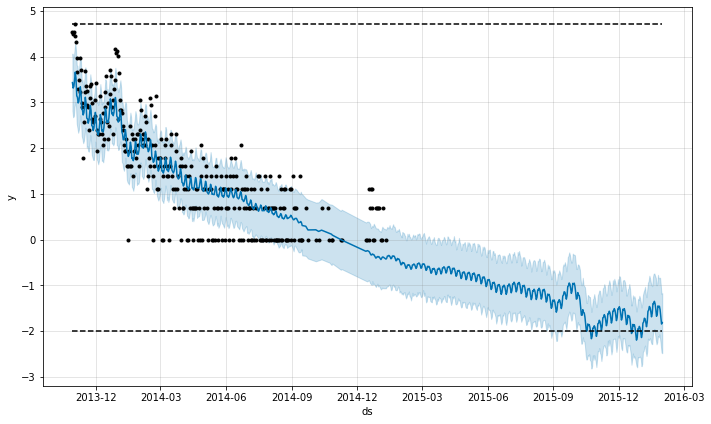

In [9]:
fig1 = m.plot(forecast)

In [10]:
# 30 days of November
np.exp(forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat'])

625    0.129879
626    0.158957
627    0.160949
628    0.171603
629    0.167246
630    0.153319
631    0.137929
632    0.148395
633    0.181552
634    0.183062
635    0.194188
636    0.187925
637    0.170842
638    0.152340
639    0.162758
640    0.198055
641    0.198356
642    0.209256
643    0.201390
644    0.182135
645    0.161694
646    0.172447
647    0.209901
648    0.210001
649    0.221509
650    0.212991
651    0.192317
652    0.170359
653    0.181479
654    0.220695
Name: yhat, dtype: float64

In [11]:
# forecast for the whole month of November
np.exp(forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat']).sum()

5.4035282068355395